In [1]:
import numpy as np
from qclib.gates.ldmcu import Ldmcu
from qclib.gates.ldmcu_approx import LdmcuApprox
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt
from qclib.util import get_cnot_count

In [2]:
unitary = np.array([[0,1], [1,0]])
error = 1e-3

ldmcu_approx_test = LdmcuApprox(unitary, num_controls=100, error=error)
base_ctrl_qubits = ldmcu_approx_test._get_num_base_ctrl_qubits(unitary, error)

num_control = 12

controls_base = QuantumRegister(num_control)
target = QuantumRegister(1)

print('Com error = %.6f, o circuito terá %d controles' %(error, base_ctrl_qubits))

Com error = 0.001000, o circuito terá 13 controles


## Gráfico ldmcu vs Lmdcu_approx utilizando o operador X

In [3]:
def circuits(unitary, error, base_ctrl_q, max_contrl_q):

    target = QuantumRegister(1)
    real_circuit = []
    approx_circuit = []
    n_controls_approx = []
    for size in range(base_ctrl_q, max_contrl_q):
        controls_base = QuantumRegister(size)

        # faz append do numero de Cnots do circuito real.
        circuit_1 = QuantumCircuit(controls_base, target)
        Ldmcu.ldmcu(circuit_1, unitary, controls_base, target)
        ldmcut = transpile(circuit_1, basis_gates=['u', 'cx'])
        ldmcu_ops = ldmcut.count_ops()
        n_cnot_real = ldmcu_ops['cx']
        real_circuit.append(n_cnot_real)

        # faz append do numero de Cnots circuito aproximado.
        circuit_2 = QuantumCircuit(controls_base, target)
        LdmcuApprox.ldmcu_approx(circuit_2, unitary, controls_base, target, error)
        ldmcu_approxt = transpile(circuit_2, basis_gates=['u', 'cx'])
        ldmcu_approx_ops = ldmcu_approxt.count_ops()
        n_cnot_approx = ldmcu_approx_ops['cx']
        if True: #n_cnot_approx <= n_cnot_real:
            approx_circuit.append(ldmcu_approx_ops['cx'])
            #n_controls_approx.append(size)

    return real_circuit, approx_circuit #, n_controls_approx

In [4]:
unitary = np.array([[0,1], [1,0]]) #MCX
error = 10e-4
#ldmcu_approx_test = LdmcuApprox(unitary, num_controls=100, error=error)
base_ctrl_qubits = ldmcu_approx_test._get_num_base_ctrl_qubits(unitary, error)

In [5]:
base_ctrl_q = base_ctrl_qubits
max_contrl_q = base_ctrl_qubits + 40
control_qubits = np.arange(base_ctrl_q, max_contrl_q)

In [6]:
cir_real_cnots, cir_approx_cnots = circuits(unitary, error, base_ctrl_q, max_contrl_q)

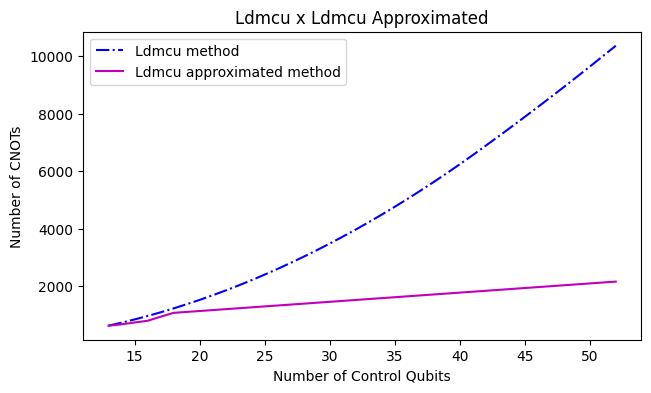

In [7]:
plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.plot(
    control_qubits, cir_real_cnots, 'b-.',
    control_qubits, cir_approx_cnots, 'm-'
)

plt.legend(
    ('Ldmcu method', 'Ldmcu approximated method'),
    loc='upper left', shadow=False
)
#plt.grid(True)
plt.title('Ldmcu x Ldmcu Approximated')
plt.xlabel('Number of Control Qubits')
plt.ylabel('Number of CNOTs')
plt.savefig("ldmcu_approx.svg", dpi=600, bbox_inches='tight')
plt.show()

## Comparação mxc

In [8]:
u = np.array([[0,1], [1,0]])
error=1e-3
ldmcu_approx_dummy = LdmcuApprox(u, num_controls=100, error=error)
base_ctrl_qubits_mcx = ldmcu_approx_dummy._get_num_base_ctrl_qubits(u,error)
print(base_ctrl_qubits_mcx)

13


In [9]:
cnot_approx=[]
cnot_original = []
base_limit = base_ctrl_qubits_mcx+25
for n_controls in range(base_ctrl_qubits_mcx, base_limit):

    controls = QuantumRegister(n_controls)
    target = QuantumRegister(1)
    circuit_approx = QuantumCircuit(controls, target)
    LdmcuApprox.ldmcu_approx(circuit_approx, u, controls, target, error)

    cnot_approx.append(get_cnot_count(circ=circuit_approx))
    circuit_og = QuantumCircuit(controls, target)
    Ldmcu.ldmcu(circuit_og, u, controls, target)
    cnot_original.append(get_cnot_count(circ=circuit_og))

print(get_cnot_count(circ=circuit_og))
print(get_cnot_count(circ=circuit_approx))

5330
1680


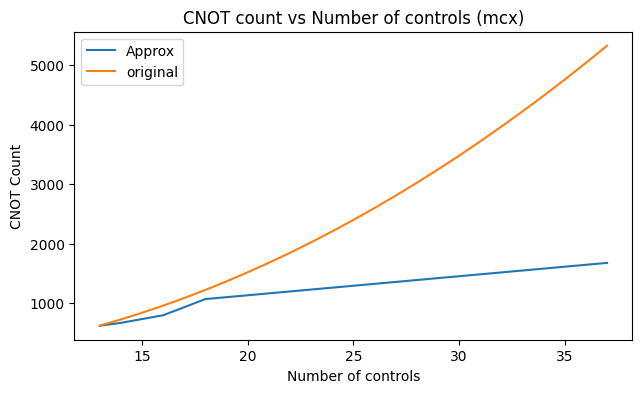

In [10]:
# x = list(range(base_ctrl_qubits_mcx, base_ctrl_qubits_mcx+100,10))
# cnot_approx_x_plot = [224, 2324, 4564, 6804, 9044, 11284, 13524, 15764, 18004, 20244]
# cnot_original_x_plot = [226, 1226, 3026, 5626, 9026, 13226, 18226, 24026, 30626, 38026]
eixo_x = list(range(base_ctrl_qubits_mcx, base_limit))
# Plot the data as a line plot
plt.plot(eixo_x, cnot_approx, label = "Approx")
plt.plot(eixo_x, cnot_original, label = "original")
# plt.plot(x, cnot_approx_x_plot, label = "Approx")
# plt.plot(x, cnot_original_x_plot, label = "Original")

# Add labels to the axes and a title to the graph
plt.xlabel('Number of controls')
plt.ylabel('CNOT Count')
plt.title('CNOT count vs Number of controls (mcx)')

# Display the graph
plt.legend()
plt.show()

## Comparação analítica

In [11]:
def custo_og(eta, m):
    return 4*(eta+m)**2 -12*(eta+m)+10

def custo_approx(eta,m):
    return 4*(eta-2)**2 + 2*(eta-2) * (16*m-8)

#def custo_otimizado(nbase, nextra):
#    return 4*(nbase - 1)**2 + 16*(nextra + 2) - 40 + 48*(nbase - 2)
#    return 4*(eta-2)**2 + 64*eta - 304 + 32*(eta + m)

def custo_terema3(base, extra):
    return 4*(base-1)**2 + 96*base+32*extra-208 - 64*(base - 2) # ultima parcela era - 32*(base - 2)

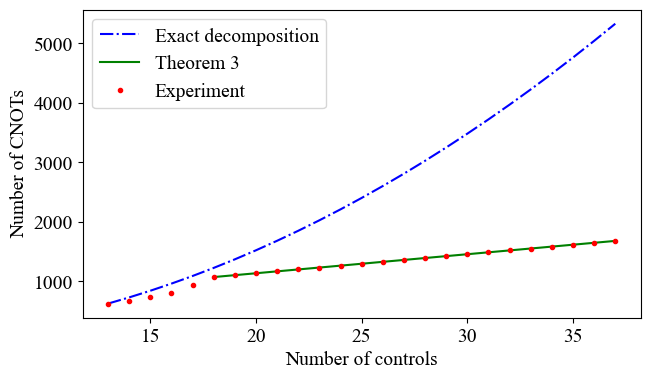

In [12]:
# x = list(range(base_ctrl_qubits_mcx, base_ctrl_qubits_mcx+100,10))
# cnot_approx_x_plot = [224, 2324, 4564, 6804, 9044, 11284, 13524, 15764, 18004, 20244]
# cnot_original_x_plot = [226, 1226, 3026, 5626, 9026, 13226, 18226, 24026, 30626, 38026]
eixo_x = list(range(base_ctrl_qubits_mcx, base_limit))
eixo_xt3 = list(range(base_ctrl_qubits_mcx+5, base_limit))
n_base = base_ctrl_qubits_mcx
analitico_otimizado_z_plot = [custo_terema3(n_base, xi - n_base) for xi in eixo_xt3]
# Plot the data as a line plot
plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})

plt.plot(eixo_x, cnot_original, 'b-.')
plt.plot(eixo_xt3, analitico_otimizado_z_plot, 'g-')
plt.plot(eixo_x, cnot_approx, 'r.')

#plt.plot(eixo_x, analitico_otimizado_z_plot, 'r-.')
# plt.plot(x, cnot_approx_x_plot, label = "Approx")
# plt.plot(x, cnot_original_x_plot, label = "Original")

plt.legend(
    ('Exact decomposition', 'Theorem 3', 'Experiment'),
    loc='upper left', shadow=False
)

# Add labels to the axes and a title to the graph
plt.xlabel('Number of controls')
plt.ylabel('Number of CNOTs')
#plt.title('CNOT count vs Number of controls (mcx)')
plt.savefig('comparacao_analito_numerico.svg', dpi=600, bbox_inches='tight')
plt.savefig('comparacao_analito_numerico.png', dpi=600, bbox_inches='tight')
# Display the graph
plt.show()

In [13]:
cnot_approx1 = cnot_approx#[5:]
print(len(cnot_approx1))
print(len(analitico_otimizado_z_plot))
for i in range(5):
    analitico_otimizado_z_plot.insert(0, 0)

for idx, element in enumerate(cnot_approx1):
    print(element - analitico_otimizado_z_plot[idx])

25
20
624
672
736
800
936
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [14]:
print('experimental T3: ', cnot_approx[0:10])
print('theorem T3: ', analitico_otimizado_z_plot[0:10])
print('PRA: ', cnot_original[0:10])
diff = np.subtract(cnot_approx[0:10], cnot_original[0:10])
print(diff)
dic = dict(zip(np.arange(13,23), diff))
print(dic)

experimental T3:  [624, 672, 736, 800, 936, 1072, 1104, 1136, 1168, 1200]
theorem T3:  [0, 0, 0, 0, 0, 1072, 1104, 1136, 1168, 1200]
PRA:  [626, 730, 842, 962, 1090, 1226, 1370, 1522, 1682, 1850]
[  -2  -58 -106 -162 -154 -154 -266 -386 -514 -650]
{13: -2, 14: -58, 15: -106, 16: -162, 17: -154, 18: -154, 19: -266, 20: -386, 21: -514, 22: -650}


In [15]:
t = np.arange(1,19)
y_1 = 14*t
y_2 = 18 + 12*t
diff = np.subtract( y_1, y_2)
idx = np.where(diff == 0)

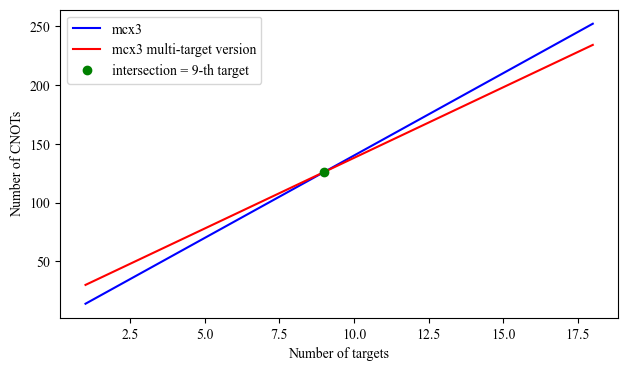

In [16]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 10})
plt.plot(t, y_1, "b-")
plt.plot(t, y_2, "r-")
plt.plot(t[idx], y_1[idx],  "go")
plt.legend(
    ('mcx3', 'mcx3 multi-target version', 'intersection = %d-th target' %(t[idx])),
    loc = 'upper left', shadow=False
)
plt.xlabel('Number of targets')
plt.ylabel('Number of CNOTs')
plt.savefig('caso_otimizado_3-controles.png', dpi=300)
plt.show()


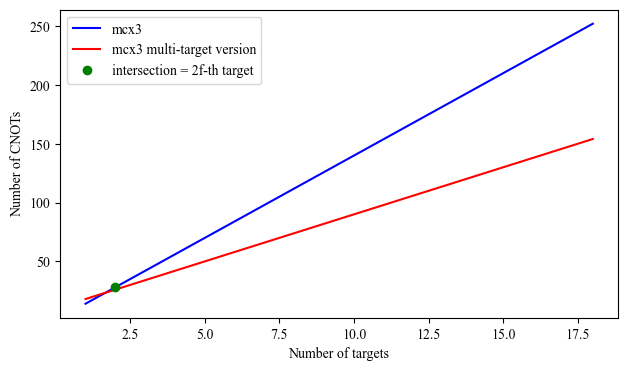

In [17]:
T = np.arange(1,19)
y_1 = 14*(T)
y_2 = 18 + 8*(T-1)
diff = np.subtract(y_1, y_2)
idx = np.where(diff == 2)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 10})
plt.plot(T, y_1, "b-")
plt.plot(T, y_2, "r-")
plt.plot(T[idx], y_1[idx],  "go")
plt.legend(
    ('mcx3', 'mcx3 multi-target version', 'intersection = %df-th target' %(T[idx])),
    loc = 'upper left', shadow=False
)
plt.xlabel('Number of targets')
plt.ylabel('Number of CNOTs')
plt.savefig('caso_otimizado_3-controles.png', dpi=300)
plt.show()

## gráfico para artigo Analítico (theorem 1 versus theorem 3)

In [18]:
# def custo_terema3(base, extra):
#     return 4*(base-1)**2 + 96*base+32*extra-208 - 64*(base - 2)

def custo_terema3(n):
    return 32*n + 496

def custo_terema1(base, extra):
    return -28*(base-1)**2 + 2*(base-1)*(16*extra - 40)

def custo_pra(n):
    return 4*n**2 - 12*n + 10

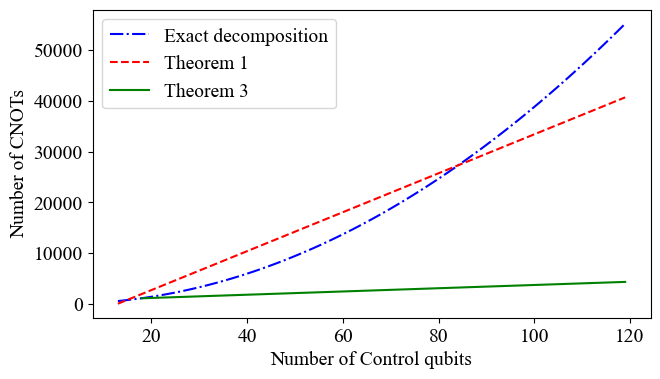

In [19]:
plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
n_base = base_ctrl_qubits_mcx
x = np.arange(n_base, 120)
x_t3 = np.arange(n_base+5, 120)
y_0 = custo_pra(x)
y_1 = custo_terema1(n_base, x)
# y_2 = [custo_terema3(n_base, xi - n_base) for xi in x_t3] #custo_terema3(n_base, x_t3)
y_2 = custo_terema3(x_t3) #custo_terema3(n_base, x_t3)

plt.plot(x, y_0, 'b-.')
plt.plot(x, y_1, 'r--')
plt.plot(x_t3, y_2, 'g-')
#plt.plot(22, custo_pra(22),  "ro") #interseção
plt.xlabel('Number of Control qubits')
plt.ylabel('Number of CNOTs')

plt.legend(
    ('Exact decomposition', 'Theorem 1', 'Theorem 3'),
    loc = 'upper left', shadow=False
)

plt.savefig('analitico_pra_t1_t3.svg', dpi=300)

In [20]:
a = np.arange(83,88)
diff = np.subtract( custo_terema1(n_base, a),custo_pra(a))
print(custo_terema1(n_base, a - n_base))
print(custo_pra(a))
print(diff)

[21888 22272 22656 23040 23424]
[26570 27226 27890 28562 29242]
[ 310   38 -242 -530 -826]


In [21]:
a = np.arange(19,23)
diff = np.subtract( custo_terema3(n_base, a - n_base),custo_pra(a))
print('CNOTs theorem 3: ', custo_terema3(n_base, a - n_base))
print('CNOTs PRA: ', custo_pra(a))
dic = dict(zip(a, diff))
print(dic)

TypeError: custo_terema3() takes 1 positional argument but 2 were given